In [1]:
# ------------------------------------------------------------------
# 0. IMPORTS Y CONFIGURACIÓN GLOBAL
# ------------------------------------------------------------------
import os
from tensorflow.keras.layers import (
    Input, Dense, Dropout, LayerNormalization, MultiHeadAttention,
    GlobalAveragePooling1D, Bidirectional, LSTM, Add
)
from tensorflow.keras import Model
from pathlib import Path

from utils.extraction import *

2025-05-13 22:33:09.367882: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1747193589.390548   26431 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1747193589.397129   26431 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1747193589.413654   26431 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747193589.413697   26431 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1747193589.413700   26431 computation_placer.cc:177] computation placer alr

In [18]:
# ----------------------- HIPERPARÁMETROS --------------------------
MODEL_TYPE       = "transformer"     # "transformer"  o  "lstm"
LABEL_SMOOTH     = 0.05
D_MODEL          = 512
NUM_HEADS        = 8
FF_DIM           = 1024
NUM_LAYERS       = 4
LSTM_UNITS       = 256
DROPOUT          = 0.3
EPOCHS           = 40
STEPS_PER_EPOCH  = 250
VAL_STEPS        = 60
WEIGHT_DECAY     = 5e-3             # Regularización L2 más fuerte
LEARNING_RATE    = 1e-4            # Ajustado para mejor convergencia

In [19]:
# ------------------------------------------------------------------
# 1. DATASETS
# ------------------------------------------------------------------
train_ds = make_dataset("train", shuffle=True)
val_ds   = make_dataset("validation", shuffle=False)

# ------------------------------------------------------------------
# 2. BLOQUES TEMPORALES
# ------------------------------------------------------------------
def transformer_block(x):
    for _ in range(NUM_LAYERS):
        attn = MultiHeadAttention(NUM_HEADS, key_dim=D_MODEL // NUM_HEADS)(x, x)
        x    = LayerNormalization()(x + Dropout(DROPOUT)(attn))
        ffn  = Dense(FF_DIM, activation="tanh")(x)
        ffn  = Dense(D_MODEL)(ffn)
        x    = LayerNormalization()(x + Dropout(DROPOUT)(ffn))
    return GlobalAveragePooling1D()(x)           # (batch, D_MODEL)

def lstm_block(x):
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=True))(x)
    x = Dropout(DROPOUT)(x)
    x = Bidirectional(LSTM(LSTM_UNITS, return_sequences=False))(x)
    return x                                      # (batch, 2*LSTM_UNITS)

def build_model() -> Model:
    inp = Input(shape=(NUM_FRAMES, 1280))

    if MODEL_TYPE == "transformer":
        # proyección + embedding posicional
        pos = tf.range(NUM_FRAMES)
        pos_emb = tf.keras.layers.Embedding(NUM_FRAMES, D_MODEL)(pos)
        x = Dense(D_MODEL)(inp) + pos_emb
        x = transformer_block(x)
    else:  # "lstm"
        x = LayerNormalization()(inp)
        x = lstm_block(x)

    x = Dropout(DROPOUT)(x)
    x = Dense(256, activation="tanh")(x)
    out = Dense(DEPTH, activation="softmax")(x)
    return Model(inp, out, name=f"engage_{MODEL_TYPE}")

model = build_model()
model.summary(line_length=120)

# ------------------------------------------------------------------
# 3. COMPILACIÓN
# ------------------------------------------------------------------
model.compile(
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE, weight_decay=WEIGHT_DECAY),
    loss=tf.keras.losses.CategoricalCrossentropy(
        from_logits=False, label_smoothing=LABEL_SMOOTH),
    metrics=["accuracy"],
)

# ------------------------------------------------------------------
# 4. CALLBACKS Y ENTRENAMIENTO
# ------------------------------------------------------------------
ckpt_dir = Path(f"checkpoints_{MODEL_TYPE}"); ckpt_dir.mkdir(exist_ok=True)
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        str(ckpt_dir / "best.weights.h5"),
        monitor="val_accuracy", mode="max",
        save_best_only=True, save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_accuracy", patience=20, restore_best_weights=True),
]

history = model.fit(
    train_ds,
    epochs            =EPOCHS,
    steps_per_epoch   =STEPS_PER_EPOCH,
    validation_data   =val_ds,
    validation_steps  =VAL_STEPS,
    callbacks         =callbacks,
)

Model: "engage_transformer"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━
┃ Layer (type)                      ┃ Output Shape                 ┃           Param # ┃ Connected to              
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━
│ input_layer_2 (InputLayer)        │ (None, 32, 1280)             │                 0 │ -                         
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_22 (Dense)                  │ (None, 32, 512)              │           655,872 │ input_layer_2[0][0]       
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add_18 (Add)                      │ (None, 32, 512)              │                 0 │ dense_22[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multi_head_attention_8            │ (None, 32, 512)              │         1,050,624 │ add_18[0][0], add_18[0][0]
│ (MultiHeadAttention)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dropout_27 (Dropout)              │ (None, 32, 512)              │                 0 │ multi_head_attention_8[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add_19 (Add)                      │ (None, 32, 512)              │                 0 │ add_18[0][0],             
│                                   │                              │                   │ dropout_27[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ layer_normalization_16            │ (None, 32, 512)              │             1,024 │ add_19[0][0]              
│ (LayerNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_23 (Dense)                  │ (None, 32, 1024)             │           525,312 │ layer_normalization_16[0][
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dense_24 (Dense)                  │ (None, 32, 512)              │           524,800 │ dense_23[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ dropout_28 (Dropout)              │ (None, 32, 512)              │                 0 │ dense_24[0][0]            
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ add_20 (Add)                      │ (None, 32, 512)              │                 0 │ layer_normalization_16[0][
│                                   │                              │                   │ dropout_28[0][0]          
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ layer_normalization_17            │ (None, 32, 512)              │             1,024 │ add_20[0][0]              
│ (LayerNormalization)              │                              │                   │                           
├───────────────────────────────────┼──────────────────────────────┼───────────────────┼───────────────────────────
│ multi_head_attention_9            │ (None, 32, 512)              │         1,050,624 │ layer_normalization_17[0][
│ (MultiHeadAttention)              │                              │                   │ layer_normalization_17[0][
├───────────────────────────────────┼───────────────────

 Total params: 9,199,364 (35.09 MB)

 Trainable params: 9,199,364 (35.09 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/40
250/250 ━━━━━━━━━━━━━━━━━━━━ 49s 78ms/step - accuracy: 0.5845 - loss: 0.9943 - val_accuracy: 0.2745 - val_loss: 2.0965
Epoch 2/40
123/250 ━━━━━━━━━━━━━━━━━━━━ 5s 41ms/step - accuracy: 0.6909 - loss: 0.7591

KeyboardInterrupt: 

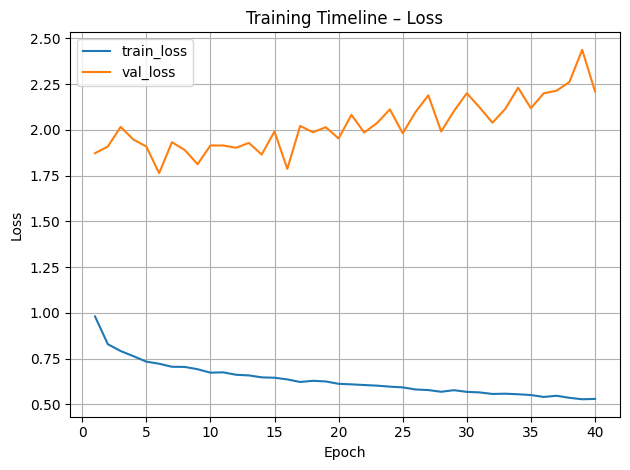

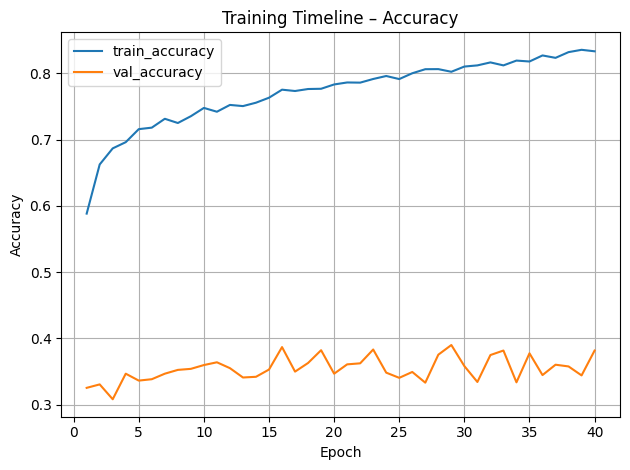

In [4]:
import matplotlib.pyplot as plt

def plot_metric(metric_name, title):
    train_values = history.history[metric_name]
    val_key      = "val_" + metric_name
    val_values   = history.history.get(val_key)

    epochs = range(1, len(train_values) + 1)

    plt.figure()                             # 1 plot por figura (sin subplots)
    plt.plot(epochs, train_values, label=f"train_{metric_name}")
    if val_values is not None:
        plt.plot(epochs, val_values, label=f"val_{metric_name}")
    plt.xlabel("Epoch")
    plt.ylabel(metric_name.capitalize())
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Traza loss y accuracy (ajusta si usas otras métricas)
plot_metric("loss",      "Training Timeline – Loss")
plot_metric("accuracy",  "Training Timeline – Accuracy")

In [ ]:
# ------------------------------------------------------------------
# 5.  EVALUACIÓN FINAL EN TEST
# ------------------------------------------------------------------
import math, glob
from sklearn.metrics import confusion_matrix, classification_report

# a) dataset de test (mismo formato: one-hot)  ──────────────────────
test_ds = make_dataset("test", shuffle=False)

# b) nº de muestras reales para limitar los steps
test_files = []
for cls in CLASSES:
    test_files += glob.glob(os.path.join(OUTPUT_FEATURES, cls, "test", "*.npy"))
N_TEST      = len(test_files)
TEST_STEPS  = math.ceil(N_TEST / BATCH_SIZE)

print(f"\nEvaluando en test ({N_TEST} vídeos)…")
test_loss, test_acc = model.evaluate(test_ds, steps=TEST_STEPS, verbose=1)
print(f"Loss={test_loss:.4f}  |  Accuracy={test_acc:.4f}")


Evaluando en test (527 vídeos)…
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step - accuracy: 0.3438 - loss: 2.0734
Loss=2.0734  |  Accuracy=0.3438


2025-05-13 22:45:56.444501: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


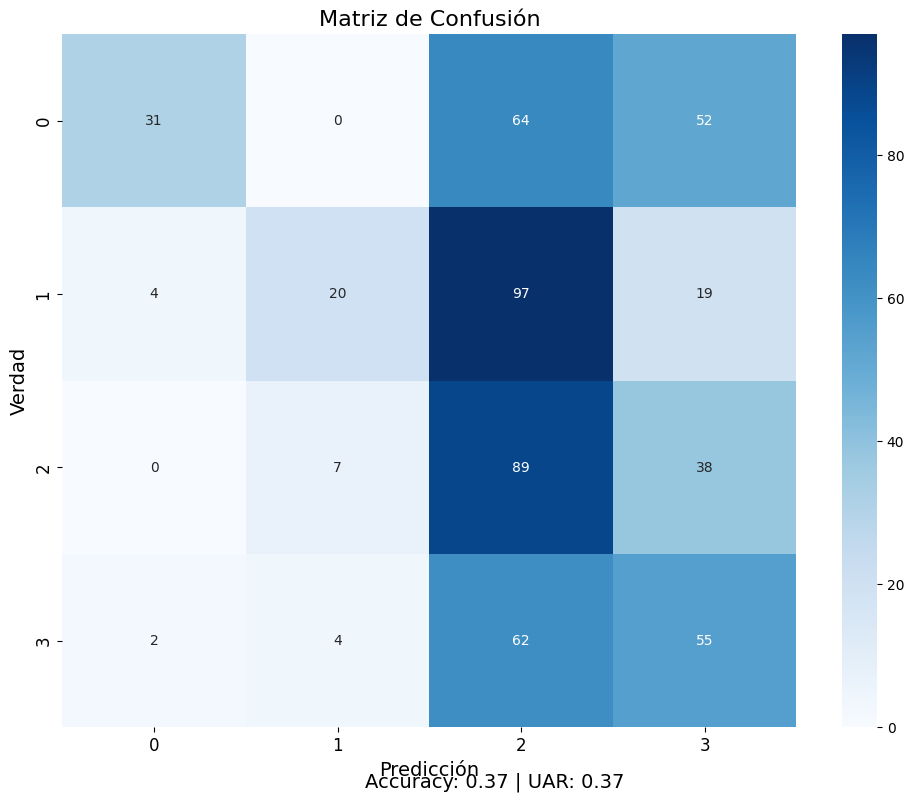


Matriz de confusión (filas=verdad, columnas=predicción):
[[31  0 64 52]
 [ 4 20 97 19]
 [ 0  7 89 38]
 [ 2  4 62 55]]


In [7]:
# ------------------------------------------------------------------
# 6.  MATRIZ DE CONFUSIÓN
# ------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns

y_true, y_pred = [], []

for xb, yb in test_ds.take(TEST_STEPS):
    preds = model.predict(xb, verbose=0)
    y_true.append(tf.argmax(yb, axis=1).numpy())       # (batch,)
    y_pred.append(tf.argmax(preds, axis=1).numpy())    # (batch,)

y_true = np.concatenate(y_true)
y_pred = np.concatenate(y_pred)

# Calcular matriz de confusión
cm = confusion_matrix(y_true, y_pred, labels=range(DEPTH))

# Visualizar la matriz
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=CLASSES, 
            yticklabels=CLASSES)

# Mejorar la visualización
plt.xlabel('Predicción', fontsize=14)
plt.ylabel('Verdad', fontsize=14)
plt.title('Matriz de Confusión', fontsize=16)

# Personalizar los ejes
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# Calcular precisión por clase para el título
class_acc = np.diag(cm) / np.sum(cm, axis=1)
acc_str = f"Accuracy: {test_acc:.2f} | UAR: {np.mean(class_acc):.2f}"
plt.figtext(0.5, 0.01, acc_str, ha="center", fontsize=14)

plt.tight_layout()
plt.show()

# También mostrar la matriz numérica para referencia
print("\nMatriz de confusión (filas=verdad, columnas=predicción):")
print(cm)

In [8]:

# ------------------------------------------------------------------
# 7.  REPORTE DE MÉTRICAS P,R,F1
# ------------------------------------------------------------------
print("\nReporte clasificación:")
target_names = [f"Clase {c}" for c in CLASSES]
print(classification_report(y_true, y_pred, target_names=target_names, digits=4))



Reporte clasificación:
              precision    recall  f1-score   support

     Clase 0     0.8378    0.2109    0.3370       147
     Clase 1     0.6452    0.1429    0.2339       140
     Clase 2     0.2853    0.6642    0.3991       134
     Clase 3     0.3354    0.4472    0.3833       123

    accuracy                         0.3585       544
   macro avg     0.5259    0.3663    0.3383       544
weighted avg     0.5385    0.3585    0.3362       544



In [9]:
# -----------------------------------------------------------------
# 8. MÉTRICA UAR (Unweighted Average Recall)
# -----------------------------------------------------------------
from sklearn.metrics import confusion_matrix

def uar_score(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred, labels=list(range(len(CLASSES))))
    recalls = np.diag(cm) / np.maximum(cm.sum(axis=1), 1)   # evita división por 0
    return recalls.mean()

uar = uar_score(y_true, y_pred)
print(f"\nUAR (macro-recall sin ponderar): {uar:.4f}")


UAR (macro-recall sin ponderar): 0.3663
